In [1]:
import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras

from FyeldGenerator import generate_field
import colorcet as cc

INFO:2025-10-23 16:00:01,387:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:bayesflow:Using backend 'jax'


In [2]:
def generate_power_spectrum(alpha, scale):
    def power_spectrum(k):
        base = np.power(k, -alpha) * scale**2
        return base

    return power_spectrum


def distribution(shape=(32, 32)):
    a = np.random.normal(loc=0, scale=1., size=shape)
    b = np.random.normal(loc=0, scale=1., size=shape)
    return a + 1j * b

In [3]:
shape = (32, 32)
n_examples = 5
alphas = np.linspace(2, 5, n_examples)
spectra = [generate_power_spectrum(alpha, 1) for alpha in alphas]

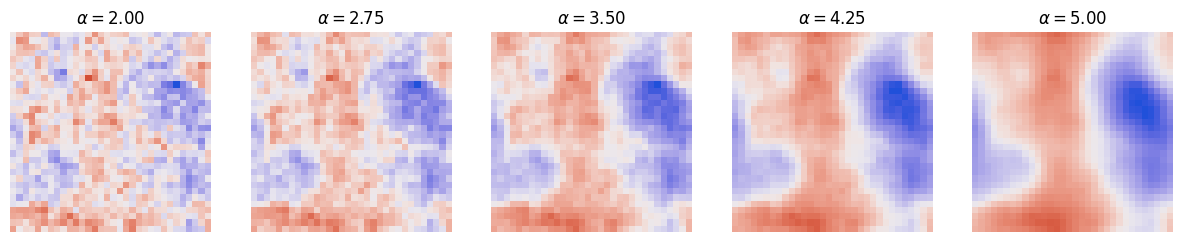

In [4]:
def plot_distribution(shape=shape):
    rng = np.random.default_rng(seed=42)
    a = rng.normal(loc=0, scale=1., size=shape)
    b = rng.normal(loc=0, scale=1., size=shape)
    return a + 1j * b
fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 4))

for power_spectrum, alpha, ax in zip(spectra, alphas, axs):
    
    field = generate_field(plot_distribution, power_spectrum, shape)
    max_magnitude = np.max(np.abs(field))
    ax.imshow(field, cmap=cc.cm.coolwarm, vmin=-max_magnitude, vmax=max_magnitude)
    ax.set_title(f"$\\alpha={alpha:.2f}$")
    ax.set_axis_off()

In [5]:
rng = np.random.default_rng()


def prior():
    log_std = rng.normal(scale=0.3)
    alpha = rng.normal(loc=3, scale=0.5)
    params_expanded = np.array([log_std, alpha])
    params_expanded = np.ones(shape + (2,)) * params_expanded[None, None, :]
    return {
        "log_std": log_std,
        "alpha": alpha,
        "params_expanded": params_expanded
    }


def likelihood(log_std, alpha):
    field = generate_field(
        distribution, generate_power_spectrum(alpha, np.exp(log_std)), shape
    )

    return {"field": field[..., None] / 50.}


simulator = bf.make_simulator([prior, likelihood])

In [6]:
@bf.utils.serialization.serializable("custom")
class ResNetSubnet(bf.networks.SummaryNetwork):
    def __init__(
        self,
        widths=(8, 16, 32),
        activation="mish",
        **kwargs,
    ):

        super().__init__(**kwargs)

        layers = [keras.layers.Conv2D(width, kernel_size=3, activation=activation, padding='SAME') for width in widths]
        self.net = bf.networks.Sequential(layers)

    def build(self, x_shape, t_shape, conditions_shape):
        self.net.build(x_shape[:-1] + (4,))

    def call(self, x, t, conditions, training=False):
        t = keras.ops.broadcast_to(t, keras.ops.shape(x)[:-1] + (1,))
        return self.net(keras.ops.concatenate((x, t, conditions), axis=-1), training=training)
    
    def compute_output_shape(self, x_shape, t_shape, conditions_shape):
        return x_shape[:-1] + (32,)

In [7]:
training_data = simulator.sample(5000)
validation_data = simulator.sample(50)

In [8]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .rename("params_expanded", "inference_conditions")
    .rename("field", "inference_variables")
)

## Training

In [9]:
inference_network = bf.networks.DiffusionModel(subnet=ResNetSubnet, concatenate_subnet_input=False)

workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    inference_network=inference_network,
    adapter=adapter,
    standardize=None,
)

In [10]:
history = workflow.fit_offline(
    data=training_data,
    epochs=100,
    validation_data=validation_data,
    batch_size=16,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2709 - val_loss: 0.7012
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.7666 - val_loss: 0.4453
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.3224 - val_loss: 0.1734
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.1693 - val_loss: 0.1401
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 0.1251 - val_loss: 0.0971
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.1100 - val_loss: 0.0905
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.0941 - val_loss: 0.0649
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.0879 - val_loss: 0.0696
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.0763 - val_loss: 0.0779
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.0768 - val_loss: 0.1486
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0644 - val_loss: 0.0536
Epoch 12/100
313/313 

KeyboardInterrupt: 

In [57]:
workflow.approximator.inference_network.base_distribution.dims

(32, 32, 1)

In [60]:
inference_network is workflow.approximator.inference_network

True

In [58]:
validation_data = simulator.sample(1)

In [74]:
z = keras.random.normal((1, 32, 32, 1))
conditions = keras.ops.convert_to_tensor(validation_data["params_expanded"], dtype="float32")


sample = inference_network(z, conditions=conditions, inverse=True)

In [75]:
sample = keras.ops.convert_to_numpy(sample)

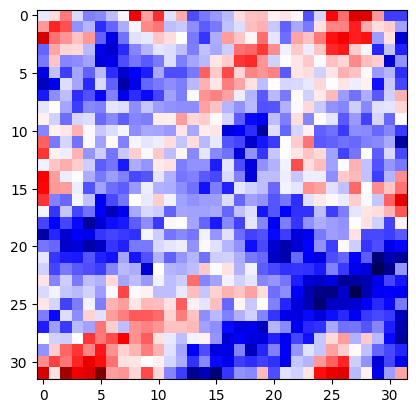

In [76]:
plt.imshow(sample[0], cmap="seismic")

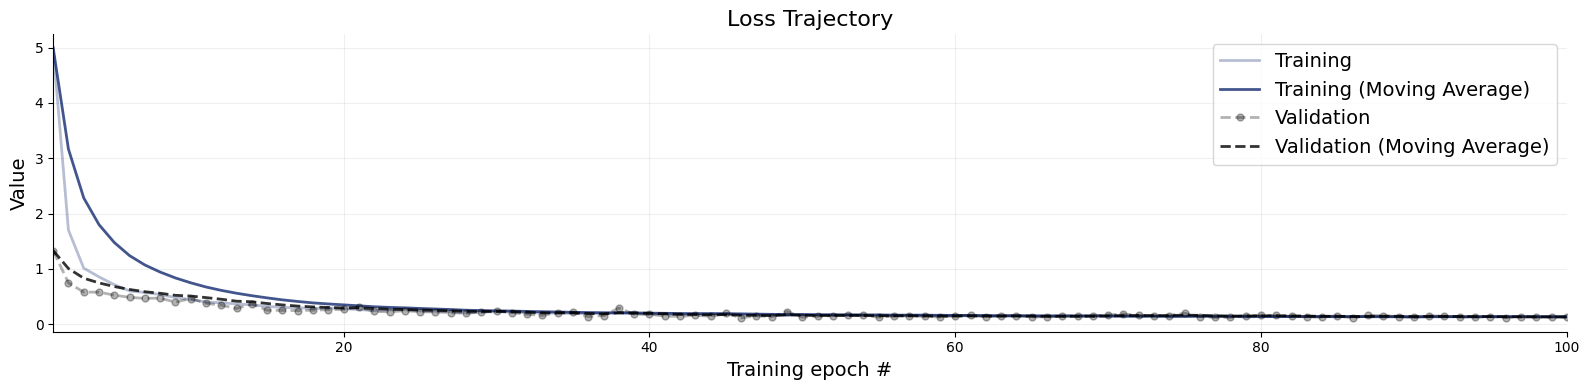

In [65]:
f = bf.diagnostics.plots.loss(history)

{'recovery': <Figure size 1000x500 with 2 Axes>,
 'calibration': <Figure size 1000x500 with 2 Axes>}

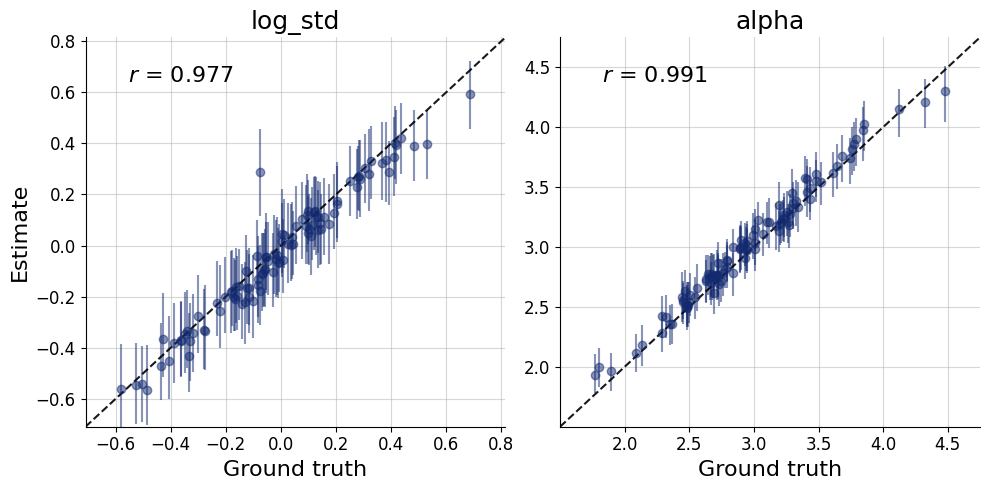

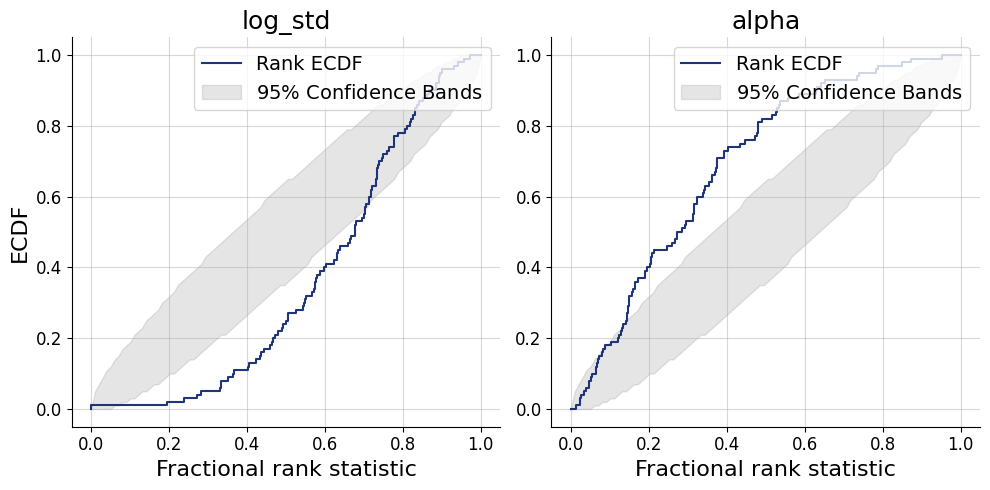

In [66]:
small_training_data = {k: v[:100] for k,v in training_data.items()}

workflow.plot_custom_diagnostics(
    test_data=test_data,
    plot_fns={
        "recovery": bf.diagnostics.recovery,
        "calibration": bf.diagnostics.calibration_ecdf,
    },
)